## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dat
import pickle
import re
import datetime
from statistics import mode
# from pathlib import Path

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

# preprocessing tool
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# modeling tool
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier

# novelty detection models
from sklearn.svm import OneClassSVM
from  sklearn.ensemble import IsolationForest
from  sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope


from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# font1 = {'family':'serif','color':'blue','size':30}
# font2 = {'family':'serif','color':'darkred','size':30}
# font2 = {'family':'serif','color':'red','size':30}

## Helper Functions
To extract flow metrics from traffic flow data and for the modeling

In [2]:
# PREPROCESSING
def extract_tcp_flag(n):
    '''
    to extract TCP flag from the info column
    '''
    pattern = r"\d\[\w*\W*\w*]|\W\[\w*\W*\w*]"
    pattern2 = r"[A-Z]{3}"
    a = ''.join(re.split("\s", n))
    b = re.findall(pattern, a)
    p = re.findall(pattern2, b[0]) if b else ''
    p = ''.join([f[0] for f in p])
    return p

def get_tcp_flag(n):
    '''
    used to extract TCP flag from the "TCP Flags" column
    '''
    return ''.join(re.findall("[a-zA-Z]", n)) 

def scale_data (data, scaler):       
    scaled_X = scaler.transform(data) 
    return pd.DataFrame(scaled_X, columns=data.columns)

def difference_fist_last(x):
    return x.iloc[-1] - x.iloc[0]

# def strip_seconds (time):
#     'return the seconds and microseconds part of a timedelta object as a float (sec.microseconds)'
#     return round(float(str(time).split()[2].split(':')[2]),5)

# def  calc_diff (item):
#   "return as list the differences between two consecutive numbers in a list"
#   diff = item.rolling(window=2).apply(difference_fist_last)
#   return diff
  
def microsec_between_fist_last(x):
    return (x.iloc[-1] - x.iloc[0]).total_seconds() * 1000

def calc_time_diff (timer):
  "return as list the milliseconds difference between two consecutive timedelta object"
  t_diff = [0.00]
  _ = [t_diff.append((b-a).total_seconds() * 1000) for a, b in zip(timer, timer[1:])]
  return t_diff
    
# MODEL EVALUATION
def print_model_eval (y_true, y_pred):    
    accuracy = sklearn.metrics.accuracy_score
    b_accuracy = sklearn.metrics.balanced_accuracy_score
    print('='*50)
    print('Accuracy: ', accuracy(y_true, y_pred))  
    print('Balance Accuracy: ', b_accuracy(y_true, y_pred))
    print('='*50)

# VISUALIZATION
def get_pca (df, scale=True): 
    pca = sklearn.decomposition.PCA(n_components=2)
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)]) if scale else Pipeline([('pca', pca)])
    pca_df = pipe.fit_transform(df)
    print('PCA explained variance ratio:', pca.explained_variance_ratio_)
    return pca_df
                     
# Predicted label visualisation
def plot_pred_label (pca_data, y_pred, title = 'using label encoding'):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_pred, alpha=None, 
                    palette= "tab10"
                   )
    plot.set(title = f"Predicted label visualisation ({title})")
    plt.show() 

# True label visualisation
def plot_true_label (pca_data, y_true, title = 'one-hot'):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_true, alpha=None, 
                    palette= "tab10"
                   )
    plot.set(title = f"True label visualisation ({title})")
    plt.show()

# MAKE FLOW DATA
def extract_flow_metrics(rolling_df, flow_dt): 
    'for extracting flow metric from traffic data and return it as a dictionary' 
    # transform the data
    rolling_df = rolling_df.replace(np.nan, '')   # to avoid the error presented by 'NaN'
    
    # TCP Flag variation
    try: 
        TCP_flags = list(map(get_tcp_flag, rolling_df['TCP Flags'])) 
    except:
        TCP_flags = list(map(extract_tcp_flag, rolling_df.Info)) 

    flow_dt['count_tcp_flags'].append(len(set(TCP_flags)))
    flow_dt['count_syn_flag'].append(''.join(TCP_flags).count('S'))
    flow_dt['count_ack_flag'].append(''.join(TCP_flags).count('A'))
    flow_dt['count_fin_flag'].append(''.join(TCP_flags).count('F'))
    flow_dt['count_rst_flag'].append(''.join(TCP_flags).count('R'))
    flow_dt['count_psh_flag'].append(''.join(TCP_flags).count('P'))

    # protocol variation
    flow_dt['count_icmp'].append(rolling_df.Protocol.tolist().count('ICMP'))
    flow_dt['count_udp'].append(rolling_df.Protocol.tolist().count('UDP'))
    flow_dt['count_tcp'].append(rolling_df.Protocol.tolist().count('TCP'))  
    flow_dt['count_tls'].append(rolling_df.Protocol.tolist().count('TLSv1.2'))   # track presense of encrypted packets
    flow_dt['count_ntp'].append(rolling_df.Protocol.tolist().count('NTP'))  
    flow_dt['count_dns'].append(rolling_df.Protocol.tolist().count('DNS'))  
    flow_dt['no_unique_prot'].append(len(rolling_df.Protocol.unique()))
    
    # flow_dt['ave_pack_IAT'].append(calc_diff(rolling_df.time_ff).mean())
    # flow_dt['flow_dur'].append(difference_fist_last(rolling_df.time_ff)  
    
    flow_dt['ave_pack_IAT'].append(np.mean(calc_time_diff(rolling_df.Time)))
    flow_dt['flow_dur'].append(microsec_between_fist_last(rolling_df.Time))

    flow_dt['no_unique_pl'].append(len(rolling_df.Length.unique()))
    if mode(rolling_df["Sequence Number"]) == '':
        flow_dt['sn_type'].append(-1) 
    elif mode(rolling_df["Sequence Number"]) > 0:
        flow_dt['sn_type'].append(1) 
    else:
        flow_dt['sn_type'].append(-1)
        
    return flow_dt 

def make_training_data(df, device_ipadd, attack_ipadd= None, roller=47, step=2):
    '''
    Group specified numbers of packets together, extract flow metric and make the flow data
    for training the model
    '''  
    # Verify that the required columns are present and correctly named
    required_col = ['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Sequence Number', 'Info']
    assert all([i in df.columns.tolist() for i in required_col]), f"The following columns are required: {[i for i in required_col if i not in list(df.columns)]}"
    
    flow_dt = {'pkt_start':[], 'pkt_end':[], 'flow_dur':[], 'ave_pack_IAT':[],'count_tcp_flags':[], 
                'count_syn_flag':[], 'count_ack_flag':[], 'count_fin_flag':[], 'count_rst_flag':[], 'count_psh_flag':[], 
                'count_tcp':[], 'count_tls':[],'count_icmp':[], 'count_udp':[],  'count_ntp':[], 'count_dns':[], 
                'no_unique_prot':[], 'no_unique_pl':[], 'sn_type':[]
            }
    
    # df.rename(columns = {'Time since reference or first frame':'time_ff'}, inplace=True) #to conveniently use the column name

    # if device_ipadd: data = df.query(f'Source == "{device_ipadd}" | Destination == "{device_ipadd}"')  # to filter out background noise
    if attack_ipadd == None:
        df = df.query(f'Destination == "{device_ipadd}"').reset_index(drop=True)  # to filter out background noise
    else:
        df = df.query(f'Source == "{attack_ipadd}" & Destination == "{device_ipadd}"').reset_index(drop=True)  # to filter out background noise
    assert  len(df) > 0, 'Confirm that the correct device IP address is provided. All the traffic count been filtered out as background noise.'
    # print(df) # for debugging

    flow_id = 1
    start = 0
    roller = roller
    step = step
    print('Sliding Window set at', 1+roller+step)

    for r in range(0, len(df), step):                               
        if (r+roller > len(df)): 
    #         print (start, ':', len(df))
            flow_dt['pkt_start'].append(start)
            flow_dt['pkt_end'].append(len(df))
            rolling_df = df[start:end]
        else :
            if r == 0:
                continue 
            else:
                end = r+roller
    #             print(start, ':', r+roller)
                rolling_df = df[start:end]
                flow_dt['pkt_start'].append(start)
                flow_dt['pkt_end'].append(end)
                
        flow_dict = extract_flow_metrics(rolling_df, flow_dt)
        start = r
        flow_id+= 1
    print('Done extracting flow data')
    return pd.DataFrame.from_dict(flow_dict).iloc[:,0:]

def make_modeling_data(datalist, device_ipadd, attack_ipadd, df_name='', roller=7, step=2, save_to_csv=True):
    '''
    Extract flow data from series of traffic data and combine all the data together to make a single data for trainig or testing our model
    '''
    all_flow_dt = pd.DataFrame()
    for d in datalist:
        if d.name.unique()[0] == 'Normal01': 
            flow_data = make_training_data(d, device_ipadd="192.168.0.101", roller=roller, step=step)
        elif d.name.unique()[0] == 'Normal02':
            flow_data = make_training_data(d, device_ipadd="rcr-663.local", roller=roller, step=step)
        else:
            flow_data = make_training_data(d, device_ipadd, attack_ipadd, roller=roller, step=step)
        flow_data['label'] = d.name.unique()[0]
    #     flow_data.to_csv(f'{d.name.values[0]}_flow.csv')
        all_flow_dt=pd.concat([all_flow_dt, flow_data], ignore_index=True)
        print(f'Done with {d.name.unique()[0]}')    
    print('Done with all the data')
    if save_to_csv: all_flow_dt.to_csv(f'../data/Training_data/{df_name}_v1.0.csv')
    return all_flow_dt

## Modeling

#### Extract flow data and make the training data

In [3]:
# # read all data
from helpers import read_multifiles
train = read_multifiles(basepath = '../data/large_data/data_2509/train', datalist = [], pickle_file=False)
# [print(n.name[0]) for n in train]   # view the arrangement of the files
normal_hive_ipaddr = "192.168.0.101"
device_ipadd = "192.168.0.102"
attack_ipadd = "192.168.0.103"
training_df = make_modeling_data(train, device_ipadd, attack_ipadd, df_name='Train', roller=7, step=2, save_to_csv=True)

# # or 

# training_df = pd.read_csv('../data/Training_data/train_v1.0.csv')

training_df

processing: ICMP02.csv
processing: ICMP03.csv
processing: ICMP04.csv
processing: Normal01.csv
processing: Normal02.csv
processing: TCPSYN01.csv
processing: TCPSYN04.csv
processing: TCPSYN05.csv
processing: UDP01.csv
processing: UDP02.csv
processing: UDP03.csv
All files have now been loaded
Sliding Window set at 10
Done extracting flow data
Done with ICMP02
Sliding Window set at 10
Done extracting flow data
Done with ICMP03
Sliding Window set at 10
Done extracting flow data
Done with ICMP04
Sliding Window set at 10
Done extracting flow data
Done with Normal01
Sliding Window set at 10
Done extracting flow data
Done with Normal02
Sliding Window set at 10
Done extracting flow data
Done with TCPSYN01
Sliding Window set at 10
Done extracting flow data
Done with TCPSYN04
Sliding Window set at 10
Done extracting flow data
Done with TCPSYN05
Sliding Window set at 10
Done extracting flow data
Done with UDP01
Sliding Window set at 10
Done extracting flow data
Done with UDP02
Sliding Window set at

,pkt_start,pkt_end,flow_dur,ave_pack_IAT,count_tcp_flags,count_syn_flag,count_ack_flag,count_fin_flag,count_rst_flag,count_psh_flag,count_tcp,count_tls,count_icmp,count_udp,count_ntp,count_dns,no_unique_prot,no_unique_pl,sn_type,label
0,0,9,15.811,1.756778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP02
1,2,11,1.510,0.167778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP02
2,4,13,1.510,0.167778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP02
3,6,15,2.228,0.247556,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP02
4,8,17,2.228,0.247556,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456816,284816,284825,0.000,0.000000,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP03
456817,284818,284827,0.000,0.000000,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP03
456818,284820,284827,0.000,0.000000,1,0,0,0,0,0,0,0,0,7,0,0,1,1,-1,UDP03
456819,284822,284827,0.000,0.000000,1,0,0,0,0,0,0,0,0,5,0,0,1,1,-1,UDP03


### EDA

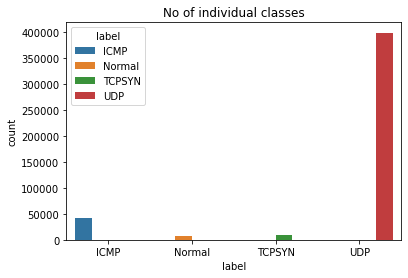

,pkt_start,pkt_end,flow_dur,ave_pack_IAT,count_tcp_flags,count_syn_flag,count_ack_flag,count_fin_flag,count_rst_flag,count_psh_flag,count_tcp,count_tls,count_icmp,count_udp,count_ntp,count_dns,no_unique_prot,no_unique_pl,sn_type,label
0,0,9,15.811,1.756778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
1,2,11,1.510,0.167778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
2,4,13,1.510,0.167778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
3,6,15,2.228,0.247556,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
4,8,17,2.228,0.247556,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
5,10,19,7.227,0.803000,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
6,12,21,7.279,0.808778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
7,14,23,6.190,0.687778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
8,16,25,6.190,0.687778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP
9,18,27,0.052,0.005778,1,0,0,0,0,0,0,0,9,0,0,0,1,1,-1,ICMP


In [4]:
#1 read in flow data 
training_df = pd.read_csv('../data/training_data/train_v1.0.csv').iloc[:,1:]
flow_data =  training_df.copy()
flow_data.label = flow_data.label.apply(lambda x: x[:-2])

# EDA
plot = sns.countplot(x= 'label', data = flow_data,
                    hue='label', palette= "tab10"
                   )
plot.set(title = "No of individual classes")
plt.show()

flow_data.head(10)

### Train Random Forest

Accuracy:  0.9942866315935409
Balance Accuracy:  0.9632778147678493
PCA explained variance ratio: [0.44230517 0.12800135]


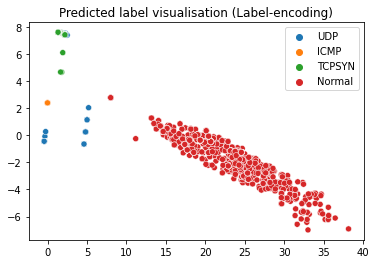

In [5]:
def make_attack_model (flow_data, scale=False, plot_eval=True):
    #2 Preprocess data
    y = flow_data['label']
    X = flow_data.drop(columns = ['pkt_start','pkt_end', 'label'])  # drop dummy column and the actual label 
    # X['av_sn'].replace([np.nan], -1, inplace=True)   # encode flows with no average sequece number (nan) with -1

    #3 create scaler and scale the data
    scaler = StandardScaler().fit(X)  
    if scale: 
        X = scale_data(X, scaler)

    #4 modeling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, shuffle=True, stratify=y)
    model = RandomForestClassifier(random_state=10).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #5 evaluate model
    print_model_eval(y_test, y_pred)
    if plot_eval:
        # visualiozation
        pca_le = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
        plot_pred_label (pca_le, y_pred, title = 'Label-encoding') # predicted label
        # plot_true_label(pca_le, y_test, 'Label-encoding')  # true label
        
    return model, scaler

model, scaler = make_attack_model(flow_data, scale=True) # for use during prediction 

# save model and scaler 
pickle.dump(scaler, open('../models/scaler_17_11', 'wb'))  
pickle.dump(model, open('../models/RF_model_17_11', 'wb')) 

### Novelty Detection

PCA explained variance ratio: [0.2132168  0.17338221]


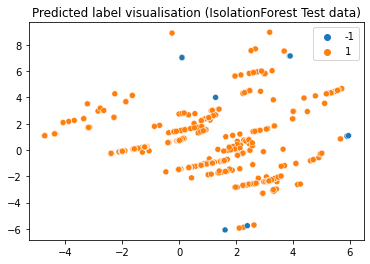

IsolationForest ===> no of test set - 1923 : no of novel data - 15
==================== ICMPprivate ====================
PCA explained variance ratio: [1.0000000e+00 7.7330743e-26]


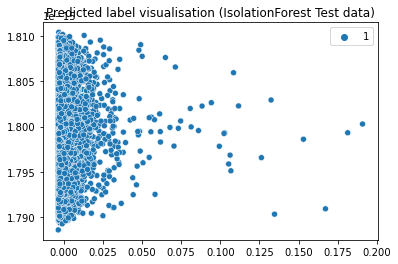

IsolationForest ===> no of test set - 15964 : no of novel data - 0
==================== TCPSYNprivate ====================
PCA explained variance ratio: [0.99652027 0.00263258]


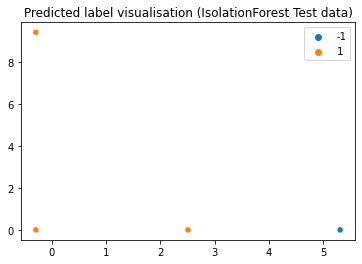

IsolationForest ===> no of test set - 44039 : no of novel data - 33
==================== UDPprivate ====================
PCA explained variance ratio: [9.99376590e-01 6.23409785e-04]


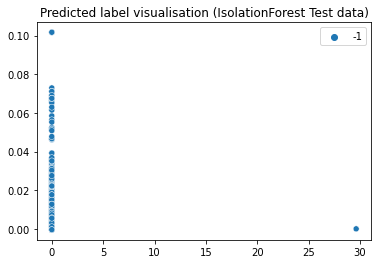

IsolationForest ===> no of test set - 156874 : no of novel data - 156874
==================== benignprivate ====================
PCA explained variance ratio: [0.22285007 0.17375706]


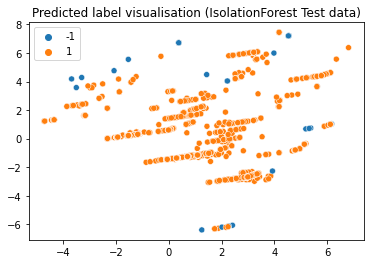

IsolationForest ===> no of test set - 4758 : no of novel data - 43
PCA explained variance ratio: [0.78894274 0.0501044 ]


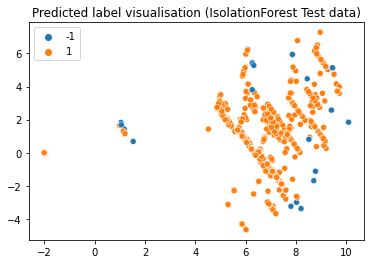

IsolationForest ===> no of test set - 20722 : no of novel data - 44


In [ ]:
# def make_novelty_model (flow_data, model=None, modelname='IsolationForest', scaler=None, scale=True, plot_eval=True, 
#                         test_size=0.3, train_model=True):
#     'If train_model is set to `False`, you must supply already fitted `model` and `scaler`\
#     '
#     #2 Preprocess data
#     y = flow_data['label']
#     X = flow_data.drop(columns = ['pkt_start','pkt_end', 'label'])  # drop dummy column and the actual label 
#     X['av_sn'].replace([np.nan], -1, inplace=True)   # encode flows with no average sequece number (nan) with -1

#     #3 create scaler and scale the data
#     if train_model: scaler = StandardScaler().fit(X)  
#     if scale: 
#         X = scale_data(X, scaler)

#     #4 split out test set (use all is already trained model is supplied i.e train_model=False)
#     if train_model:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10, shuffle=True)
#     else:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.99, random_state=10, shuffle=True)


#     #4 modeling
#     if train_model: 
#         model = IsolationForest(max_samples='auto', contamination=0.01, 
#                                 random_state=1, n_estimators=100).fit(X_train, y_train)
#     # X_Train_pred = model.predict(X_train)
#     y_pred = model.predict(X_test)

#     #5 evaluate model
#     # print_model_eval(y_test, y_pred)

#     #6 visualization
#     if plot_eval:
#         pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
#         plot_pred_label (pca_test, y_pred, title = f'{modelname} Test data') # predicted label

#         # pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
#         # plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
        
#     index = np.where(y_pred==-1)[0]
#     print(modelname, '===>', 'no of test set -', len(X_test), ':', 'no of novel data -', len(X_test.iloc[index]))

#     if train_model: return model, scaler

# flow_dt = flow_data.query("label == 'benignprivate'")
# model, scaler = make_novelty_model (flow_dt, test_size=0.4)

# # save model and scaler 
# # pickle.dump(scaler, open('../models/novelty_scaler', 'wb'))  
# # pickle.dump(model, open('../models/novelty_model', 'wb')) 

# # predict on all atack flow
# attack_labels = ['ICMPprivate', 'TCPSYNprivate', 'UDPprivate', 'benignprivate']
# for l in attack_labels:
#     # flow_dt = flow_data.query(f"label == '{attack_labels[1]}'")
#     print ('='*20, l, '='*20)
#     flow_dt = flow_data.query(f"label == '{l}'")
#     make_novelty_model (flow_dt, model=model, scaler=scaler, plot_eval=True, train_model=False)

# # trial codes for combined data
# attack_labels = ['ICMPprivate', 'TCPSYNprivate', 'UDPprivate', 'benignprivate']
# flow_dt = flow_data.query(f"label == '{attack_labels[0]}' | label == '{attack_labels[3]}'")
# make_novelty_model (flow_dt, model=model, scaler=scaler, plot_eval=True, train_model=False)

test data (Normal)

==================

OneClassSVM ===> 1442 : 37                          OneClassSVM ===> 3365 : 132

LOF ===> 1442 : 61                                  LOF ===> 3365 : 118

EllipticEnvelope ===> 1442 : 44                     EllipticEnvelope ===> 3365 : 111

IsolationForest ===> 1442 : 9                       IsolationForest ===> 3365 : 25


Almost ALL 'ICMPprivate' and 'TCPSYNprivate' detected as Normal flow

Almost ALL 'UDPprivate' detected as Normal flow


## Detection

In [31]:
def attack_detector (df, trained_model, scaler, device_ipadd=None, roller=7, step=2):
    f'''
    Predict if a tuple of {roller + step + 1} packets is an attack or normal flow by extracting
    flow metric from the {roller + step + 1} packet tuple and using the loaded model for the predict.
    '''

    if device_ipadd:
        data = df.query(f'Destination == "{device_ipadd}"') # to filter out background noise 
    else: 
        data = df 

    assert  len(data) > 0, 'Confirm that the correct device IP address is provided. All the traffic count been filtered out as background noise.'
    # print(data) # for debugging
    
#1  Extract flow data ------->flow_df = make_flow_data(traffic_df)
    flow_id = 1
    start = 0
    atk_name = []
    atk_str  = []
    atk_end = []
    atk_mode = []
    for r in range(0, len(data), step):        
        flow_dt = {'pkt_start':[], 'pkt_end':[], 'flow_dur':[], 'ave_pack_IAT':[],'count_tcp_flags':[], 
                'count_syn_flag':[], 'count_ack_flag':[], 'count_fin_flag':[], 'count_rst_flag':[], 'count_psh_flag':[], 
                'count_tcp':[], 'count_tls':[],'count_icmp':[], 'count_udp':[],  'count_ntp':[], 'count_dns':[], 
                'no_unique_prot':[], 'no_unique_pl':[], 'sn_type':[]
            }
        
        # get chunk of traffic packets (based on the defined window (roller+step+1))
        if (r+roller > len(data)): 
            flow_dt['pkt_start'].append(start)
            flow_dt['pkt_end'].append(len(data))
            rolling_df = data[start:end]
        else :
            if r == 0:
                continue 
            else:
                end = r+roller
                # print(start, ':', r+roller)
                rolling_df = data[start:end]
                flow_dt['pkt_start'].append(start)
                flow_dt['pkt_end'].append(end)
        # print(rolling_df) # for debugging

        # extract flow metrics from the chunk of traffic packets  
        flow_dict = extract_flow_metrics(rolling_df, flow_dt)
        
        # convert the flow metrics data into a dataframe
        flow_dt = pd.DataFrame.from_dict(flow_dict) 
        # print('='*10, f'flow {flow_id} : packet {start} -- packet {end}', '='*10)  # for debugging purpose
        # print(flow_dt) # for debugging purpose

#2      Preprocess the flow data
        feature = flow_dt.drop(columns = ['pkt_start','pkt_end'])  # drop dummy column and the actual label 
        # feature['av_sn'].replace([np.nan], -1, inplace=True)   # encode flows with no average sequece number (nan) with -1
        
#3      scale the flow data
        feature = scale_data(feature, scaler)
            
        packet_info = flow_dt.loc[:,['pkt_start','pkt_end']]
#         print('='*50, )    ##for debugging purpose
#         print(feature)     ##for debugging purpose

#5      make prediction
        pred = trained_model.predict(feature)[0]
        # print (pred)   ##for debugging purpose

#6      Take action based on the prediction (traffic flow type)
        if pred != 'Normal':
            print( f'"{pred}" Attack detected between packet ==> {packet_info.pkt_start[0]} and {packet_info.pkt_end[0]} (original index {rolling_df.index[0]+1} : {rolling_df.index[-1]+2})\n\
                 stop server NOW')
            atk_name.append(pred)                                                         # For monitoring or later analysis
            atk_str.append(packet_info.pkt_start[0])                                      # For monitoring or later analysis
            atk_end.append(packet_info.pkt_end[0])                                        # For monitoring or later analysis
                                                                                    
            try:                                                                      
                atk_mode.append(mode(rolling_df.Protocol))   # to guess the attack type for monitoring or later analysis
                # atk_mode.append(rolling_df.Protocol.mode().values[0])   # to guess the attack type for monitoring or later analysis
            except:                                                                     
                atk_mode.append('unknown')                   # For monitoring or later analysis
            # print (pred)   ## for debugging purpose
            break    # un/comment if you need to stop detection after first attack has been detected
        # else:                                                                        # For monitoring 
        #     print('"Normal flow"')                                                     
        # print('='*50, f'flow {flow_id} : start {end}', '='*50)  
        start = r
        flow_id+= 1
    return atk_name, atk_str, atk_end, atk_mode

### testing data

In [15]:
test = read_multifiles(basepath = '../data/large_data/data_2509/test', datalist = [], pickle_file=False)

# # use the trained model for continous monitoring
# trained_scaler = pickle.load(open('../models/scaler_17_11', 'rb')) 
# trained_model = pickle.load(open('../models/RF_model_17_11', 'rb'))
trained_scaler = scaler
trained_model = model
device_ipadd = "192.168.0.102"

# Read the data (detection - get traffic data)
for i in range(len(test)):
    traffic_df = test[i].copy()
    print(set(traffic_df.name))
    atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd, roller = 7)
    # atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 47)
    print('='*20, f'done with {set(traffic_df.name)}', '='*20)

# traffic_df = pd.read_csv('../data/large_data/data_2509/trial/normal.csv', encoding='latin1',  parse_dates = ['Time'])
# atk_name,_,_,_ =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 47)
# print(atk_name)

processing: ICMP01.csv
processing: ICMP05.csv
processing: TCPSYN02.csv
processing: TCPSYN03.csv
processing: UDP04.csv
processing: UDP05.csv
All files have now been loaded
{'ICMP01'}
"ICMP" Attack detected between packet ==> 88 and 97 (original index 581 : 609)
                 stop server NOW
========== done with {'ICMP01'} ==========
{'ICMP05'}
"ICMP" Attack detected between packet ==> 88 and 97 (original index 281 : 298)
                 stop server NOW
========== done with {'ICMP05'} ==========
{'TCPSYN02'}
"TCPSYN" Attack detected between packet ==> 98 and 107 (original index 272 : 292)
                 stop server NOW
========== done with {'TCPSYN02'} ==========
{'TCPSYN03'}
"ICMP" Attack detected between packet ==> 0 and 9 (original index 38 : 52)
                 stop server NOW
========== done with {'TCPSYN03'} ==========
{'UDP04'}
"UDP" Attack detected between packet ==> 46 and 55 (original index 179 : 205)
                 stop server NOW
========== done with {'UDP04'} ======

### Validation data

In [16]:
val = read_multifiles(basepath = '../data/large_data/data_2509/val', datalist = [], pickle_file=False)
device_ipadd = "192.168.0.102"

# Read the data (detection - get traffic data)
for i in range(len(val)):
    traffic_df = val[i].copy()
    print(set(traffic_df.name))
    atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd, roller = 7)
    # atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 47)
    print('='*20, f'done with {set(traffic_df.name)}', '='*20)

{'HTTPDDOS01'}
"TCPSYN" Attack detected between packet ==> 2 and 11 (original index 48 : 62)
                 stop server NOW
==================== done with {'HTTPDDOS01'} ====================
{'HTTPDDOS02'}
"UDP" Attack detected between packet ==> 42 and 51 (original index 122 : 133)
                 stop server NOW
==================== done with {'HTTPDDOS02'} ====================
{'HTTPDDOS03'}
"TCPSYN" Attack detected between packet ==> 50 and 59 (original index 189 : 197)
                 stop server NOW
==================== done with {'HTTPDDOS03'} ====================
{'REC,UDP,TCP,HTTP DDOS01'}
"UDP" Attack detected between packet ==> 52 and 61 (original index 265 : 323)
                 stop server NOW
==================== done with {'REC,UDP,TCP,HTTP DDOS01'} ====================
{'RECOILDDOS01X1'}
"TCPSYN" Attack detected between packet ==> 54 and 63 (original index 211 : 231)
                 stop server NOW
==================== done with {'RECOILDDOS01X1'} ================

## Public dataset

In [30]:
# test = read_multifiles(basepath = '../data/large_data/data_2509/public', datalist = [], pickle_file=False)

# # use the trained model for continous monitoring
# trained_scaler = pickle.load(open('../models/scaler_17_11', 'rb')) 
# trained_model = pickle.load(open('../models/RF_model_17_11', 'rb'))
trained_scaler = scaler
trained_model = model
device_ipadd = "192.168.1.158"

# # Read the data (detection - get traffic data)
# for i in range(len(test)):
#     traffic_df = test[i].copy()
#     print('processing', set(traffic_df.name))
#     atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd, roller = 7)
#     # atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 7)
#     print('='*30, f'done with {set(traffic_df.name)}', '='*30)

traffic_df = pd.read_csv('../data/large_data/data_2509/public/special/publicTCPSYNattack 192.168.1.195.csv', encoding='latin1',  parse_dates = ['Time'])
atk_name,_,_,_ =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 7)
print(atk_name)

"UDP" Attack detected between packet ==> 1666 and 1675 (original index 1667 : 1675)
                 stop server NOW
['UDP']


{'publicBenignA 192.168.1.158.csv'}
"ICMP" Attack detected between packet ==> 1648 and 1657 (original index 3403 : 3417)
                 stop server NOW
============================== done with {'publicBenignA 192.168.1.158.csv'} ==============================
{'publicBenignB 192.168.1.158.csv'}
============================== done with {'publicBenignB 192.168.1.158.csv'} ==============================
{'publicbenignC 192.168.1.158.csv'}
============================== done with {'publicbenignC 192.168.1.158.csv'} ==============================
{'publicbenignD 192.168.1.158.csv'}
============================== done with {'publicbenignD 192.168.1.158.csv'} ==============================
{'publicbenignE 192.168.1.158.csv'}
============================== done with {'publicbenignE 192.168.1.158.csv'} ==============================

#### Detection result (RF) 3x2 dataset

NORMAL: no attack     ----> all normal

ICMP: attack starts from packet no 58       ----> "ICMPprivate" Attack detected between packet: 56 and 60

UDP: attack starts from packet no 262       ----> "UDPprivate" Attack detected between packet: 260 and 264

_TCPSYN: attack starts from packet no 0      ----> 'TCPSYN' attack detected between parket: 0 and 4

NORMAL (Public): no attack      ----> "ICMPprivate" Attack detected between packet: 4 and 8

{'ICMP01'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'ICMP02'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'TCP03'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'TCP04'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'UDP04'}
"TCP" Attack detected between packet: 2 and 51 
 stop server NOW
TCP
{'UDP05'}
"TCP" Attack detected between packet: 4 and 53 
 stop server NOW
TCP

# Others

## Usefull codes

In [9]:
# with open('../data/large_data/pickled/benignprivate', 'rb') as f:    # file to
#     normal_df = pickle.load(f)
# normal_df.Time =  [datetime.datetime.fromtimestamp(x) for x in normal_df.Time] # Unix Time
# normal_df.rename(columns = {'Sequence number': 'Sequence Number'}, inplace=True)
# normal_df.to_csv('../data/large_data/data_2509/train/Normal02.csv')     

In [10]:
# normal_df = pd.read_csv('../data/large_data/data_2509/train/normal02.csv', encoding='latin1',  parse_dates = ['Time'])
# # normal_df.Time[10001] - normal_df.Time[10000]
# normal_df.Time[:3]

# # ic_df = pd.read_csv('../data/large_data/data_2509/trial/icmp03v2.csv', encoding='latin1',  parse_dates = ['Time'])
# # # normal_df.Time[10001] - normal_df.Time[10000]
# ic_df

In [11]:
# training_df = training_df = make_modeling_data(train[:2], device_ipadd, name='Train', roller=7, step=2, save_to_csv=False)
# n = len(traffic_df)
# y_p = KMeans(n_clusters=2).fit_predict(training_df.iloc[:n,:-1])

# pca_d = get_pca(training_df.iloc[:n,:-1])
# plot_pred_label (pca_d, y_p, title = 'using label encoding')
# plot_pred_label (pca_d, training_df.iloc[:n,-1], title = 'using label encoding')

# # training_df.iloc[:10000,-1]

In [12]:
# d = filtered_tcpsyn_df[:100]
# make_training_data(d, roller=2, step=2)

# if 'TCP Flags' in rolling_df.columns: print(' TCP Flags column present')


In [13]:
# #4 modeling (OneClassSVM)
# modelname = 'OneClassSVM'
# # model = OneClassSVM(kernel='rbf', gamma=0.05, nu=0.05).fit(X_train)
# model = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.005).fit(X_train)
# X_Train_pred = model.predict(X_train)
# X_Test_pred = model.predict(X_test)

# #5 evaluate model
# if plot_eval:
#     # visualiozation
#     pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
    
#     pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_test, X_Test_pred, title = f'{modelname} Test data') # predicted label
        
# index = np.where(X_Test_pred==-1)[0]
# print(modelname, '===>', len(X_test), ':', len(X_test.iloc[index]))
# print('='*50)

# #4 modeling (LoF)
# modelname = 'LOF'
# model = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
#                          metric='minkowski', contamination=0.04,
#                          novelty=True, n_jobs=-1)
# model = model.fit(X_train)
# X_Train_pred = model.predict(X_train)
# X_Test_pred = model.predict(X_test)

# #5 evaluate model
# # print_model_eval(y_test, y_pred)
# if plot_eval:
#     # visualiozation
#     pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
    
#     pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_test, X_Test_pred, title = f'{modelname} Test data') # predicted label

# index = np.where(X_Test_pred==-1)[0]
# print(modelname, '===>', len(X_test), ':', len(X_test.iloc[index]))
# print('='*50)

# # modeling (EllipticEnvelope)
# modelname = 'EllipticEnvelope'
# model = EllipticEnvelope(contamination=0.025, random_state=1)
# model = model.fit(X_train)
# X_Train_pred = model.predict(X_train)
# X_Test_pred = model.predict(X_test)
# # y_pred = model.predict(X_test)

# #5 evaluate model
# # print_model_eval(y_test, y_pred)
# if plot_eval:
#     # visualiozation
#     pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
    
#     pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_test, X_Test_pred, title = f'{modelname} Test data') # predicted label

# index = np.where(X_Test_pred==-1)[0]
# print(modelname, '===>', len(X_test), ':', len(X_test.iloc[index]))
# print('='*50)


# traffic_df = pd.read_csv('../data/large_data/data_2509/trial/normal.csv', encoding='latin1',  parse_dates = ['Time'])
# atk_name,_,_,_ =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 47)
# print(atk_name)